### Imports

In [81]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import circuit_drawer
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
from IPython.display import display

### Creating Shor Encoding Circuit

Applies the encoding part of the 9-qubit Shor code to a logical qubit.
This encoding protects against a single bit-flip or phase-flip error.
The logical qubit (initially at logical_qubit_index) is encoded onto 9 physical qubits (q[0] to q[8]).

Encoding steps:
- Bit-flip encoding: Three-qubit repetition code for each block.
- Phase-flip encoding: Entangle the first qubit of each block to protect against phase flips.

In [82]:
def create_shor_encoding_circuit(qc, logical_qubit_index):
    # 1. Bit-flip encoding: Protect against bit-flip errors (3-qubit repetition code)
    # Copy q[0] to q[3] and q[6]
    qc.cx(logical_qubit_index, 3)
    qc.cx(logical_qubit_index, 6)

    # Within each block, create the 3-qubit repetition code
    # Block 1: qubits 0, 1, 2
    qc.cx(0, 1)
    qc.cx(0, 2)
    # Block 2: qubits 3, 4, 5
    qc.cx(3, 4)
    qc.cx(3, 5)
    # Block 3: qubits 6, 7, 8
    qc.cx(6, 7)
    qc.cx(6, 8)

    # 2. Phase-flip encoding: Protect against phase-flip errors
    # Apply Hadamards to all qubits to transform to phase basis
    for i in range(9):
        qc.h(i)
    # Entangle first qubits of each block to create phase-flip code
    qc.cx(0, 3)
    qc.cx(0, 6)

### Introduction Error

In [83]:
def introduce_error(qc, qubit_index, error_type='bit_flip'):
    if not (0 <= qubit_index <= 8):
        print(f"Warning: Error introduced on non-data qubit {qubit_index}. Skipping error.")
        return

    if error_type == 'bit_flip':
        print(f"  Introducing a BIT-FLIP error on qubit {qubit_index}")
        qc.x(qubit_index)
    elif error_type == 'phase_flip':
        print(f"  Introducing a PHASE-FLIP error on qubit {qubit_index}")
        qc.z(qubit_index)
    elif error_type == 'bit_and_phase_flip':
        print(f"  Introducing a BIT-AND-PHASE-FLIP error on qubit {qubit_index}")
        qc.y(qubit_index)
    else:
        print(f"  No error introduced. Unknown error type: {error_type}")

### Detect and Correct Bit Flip Errors

Detects and corrects bit-flip errors for a 3-qubit block.
Uses two ancillary qubits for syndrome measurement, measured into two classical bits.

In [84]:
def detect_and_correct_bit_flip(qc, data_q_start_index, syndrome_q_start_index, syndrome_c_start_index):
    # CNOTs to entangle data qubits with syndrome qubits
    qc.cx(data_q_start_index, syndrome_q_start_index)
    qc.cx(data_q_start_index+1, syndrome_q_start_index)
    qc.cx(data_q_start_index+1, syndrome_q_start_index+1)
    qc.cx(data_q_start_index+2, syndrome_q_start_index+1)

    # Measure syndrome qubits into classical bits
    qc.measure(syndrome_q_start_index, syndrome_c_start_index)
    qc.measure(syndrome_q_start_index+1, syndrome_c_start_index+1)

    # Apply corrections based on syndrome
    with qc.if_test((qc.clbits[syndrome_c_start_index], 0b1)):
        with qc.if_test((qc.clbits[syndrome_c_start_index+1], 0b0)):
            qc.x(data_q_start_index)
    with qc.if_test((qc.clbits[syndrome_c_start_index], 0b0)):
        with qc.if_test((qc.clbits[syndrome_c_start_index+1], 0b1)):
            qc.x(data_q_start_index+2)
    with qc.if_test((qc.clbits[syndrome_c_start_index], 0b1)):
        with qc.if_test((qc.clbits[syndrome_c_start_index+1], 0b1)):
            qc.x(data_q_start_index+1)

    # Reset syndrome qubits
    qc.reset(syndrome_q_start_index)
    qc.reset(syndrome_q_start_index+1)

### Detect and Correct Phase Flip Errors

Detects and corrects phase-flip errors for the 9-qubit code.
Uses two ancillary qubits for syndrome measurement, measured into two classical bits.

In [85]:
def detect_and_correct_phase_flip(qc, bit_flip_syndrome_q_start, bit_flip_syndrome_c_start,
                                 phase_flip_syndrome_q_start, phase_flip_syndrome_c_start):
    # Convert phase errors to bit errors
    for q_idx in range(9):
        qc.h(q_idx)

    # Apply bit-flip detection/correction for each block
    detect_and_correct_bit_flip(qc, 0, bit_flip_syndrome_q_start, bit_flip_syndrome_c_start)
    detect_and_correct_bit_flip(qc, 3, bit_flip_syndrome_q_start+2, bit_flip_syndrome_c_start+2)
    detect_and_correct_bit_flip(qc, 6, bit_flip_syndrome_q_start+4, bit_flip_syndrome_c_start+4)

    # CNOTs to entangle first qubit of each block with phase syndrome qubits
    qc.cx(0, phase_flip_syndrome_q_start)
    qc.cx(3, phase_flip_syndrome_q_start)
    qc.cx(3, phase_flip_syndrome_q_start+1)
    qc.cx(6, phase_flip_syndrome_q_start+1)

    # Measure phase syndrome qubits
    qc.measure(phase_flip_syndrome_q_start, phase_flip_syndrome_c_start)
    qc.measure(phase_flip_syndrome_q_start+1, phase_flip_syndrome_c_start+1)

    # Apply corrections based on phase syndrome
    with qc.if_test((qc.clbits[phase_flip_syndrome_c_start], 0b1)):
        with qc.if_test((qc.clbits[phase_flip_syndrome_c_start+1], 0b0)):
            qc.z(0)
    with qc.if_test((qc.clbits[phase_flip_syndrome_c_start], 0b0)):
        with qc.if_test((qc.clbits[phase_flip_syndrome_c_start+1], 0b1)):
            qc.z(6)
    with qc.if_test((qc.clbits[phase_flip_syndrome_c_start], 0b1)):
        with qc.if_test((qc.clbits[phase_flip_syndrome_c_start+1], 0b1)):
            qc.z(3)

    # Reset phase syndrome qubits
    qc.reset(phase_flip_syndrome_q_start)
    qc.reset(phase_flip_syndrome_q_start+1)

    # Revert phase errors to phase-flips
    for q_idx in range(9):
        qc.h(q_idx)

### Creating Shor Decoding Circuit

Applies the decoding part of the 9-qubit Shor code, reversing the encoding to recover the logical qubit.

In [86]:
def create_shor_decoding_circuit(qc, logical_qubit_index):
    # Reverse phase-flip encoding
    qc.cx(0, 6)
    qc.cx(0, 3)
    for i in range(9):
        qc.h(i)

    # Reverse bit-flip encoding
    qc.cx(6, 8)
    qc.cx(6, 7)
    qc.cx(3, 5)
    qc.cx(3, 4)
    qc.cx(0, 2)
    qc.cx(0, 1)
    qc.cx(logical_qubit_index, 6)
    qc.cx(logical_qubit_index, 3)

### Shor Code Circuit

Constructs the full 9-qubit Shor code circuit, including encoding, error introduction,
error detection and correction, decoding, and final measurement.

Args:
-    initial_state_qubit_index (int): The index of the qubit for initial state preparation.
-    error_qubit (int, optional): The index of the physical qubit (0-8) to introduce an error on.
-    error_type (str, optional): Type of error ('bit_flip', 'phase_flip',   'bit_and_phase_flip').

In [87]:
def shor_code_full_circuit(initial_state_qubit_index=0, error_qubit=None, error_type=None):
    TOTAL_Q_QUBITS = 17  # 9 data + 6 bit-flip ancillas + 2 phase-flip ancillas
    TOTAL_C_BITS = 9  # 6 bit-flip syndromes + 2 phase-flip syndromes + 1 logical measurement

    qc = QuantumCircuit(TOTAL_Q_QUBITS, TOTAL_C_BITS)

    # Initial state preparation (default |0>)
    print(f"Preparing initial state |0> for logical qubit at index {initial_state_qubit_index}")

    # Encoding
    print("\nEncoding Circuit...")
    create_shor_encoding_circuit(qc, initial_state_qubit_index)
    qc.barrier()

    # Error introduction (optional)
    if error_qubit is not None and error_type is not None:
        print("\nIntroducing Error...")
        introduce_error(qc, error_qubit, error_type)
        qc.barrier()

    # Error detection and correction
    print("\nError Detection and Correction Circuit...")
    Q_BIT_FLIP_ANC_START = 9
    C_BIT_FLIP_SYNDROME_START = 0
    Q_PHASE_FLIP_ANC_START = 15
    C_PHASE_FLIP_SYNDROME_START = 6
    detect_and_correct_phase_flip(qc,
                                 Q_BIT_FLIP_ANC_START, C_BIT_FLIP_SYNDROME_START,
                                 Q_PHASE_FLIP_ANC_START, C_PHASE_FLIP_SYNDROME_START)
    qc.barrier()

    # Decoding
    print("\nDecoding Circuit...")
    create_shor_decoding_circuit(qc, initial_state_qubit_index)
    qc.barrier()

    # Final measurement
    print("\nFinal Measurement...")
    C_LOGICAL_MEASUREMENT = 8
    qc.measure(initial_state_qubit_index, C_LOGICAL_MEASUREMENT)

    return qc

### Running Shor Simulation

In [88]:
def run_shor_simulation(error_qubit=None, error_type=None):
    print("--------------------------------------------------")
    print("           Running Shor 9-Qubit Code Simulation   ")
    print("--------------------------------------------------")

    shor_circuit = shor_code_full_circuit(error_qubit=error_qubit, error_type=error_type)

    print("\nFull Circuit Diagram:")
    display(shor_circuit.draw(output='mpl'))

    simulator = AerSimulator()
    compiled_circuit = transpile(shor_circuit, simulator)
    job = simulator.run(compiled_circuit, shots=1024)
    result = job.result()
    counts = result.get_counts(shor_circuit)

    print("\nMeasurement Results (Classical Bits, from LSB to MSB):")
    print(counts)

    logical_qubit_results = {}
    for outcome, count in counts.items():
        logical_qubit_state = outcome[0]
        logical_qubit_results[logical_qubit_state] = logical_qubit_results.get(logical_qubit_state, 0) + count

    print("\nDecoded Logical Qubit Measurement (from c[8]):")
    print(logical_qubit_results)

    initial_logical_state_counts = logical_qubit_results.get('0', 0)
    print(f"Success Rate (Ideal |0> state): {initial_logical_state_counts / 1024 * 100:.2f}%")
    if initial_logical_state_counts > 900:
        print("Shor code successfully corrected the error!")
    else:
        print("Shor code failed to correct the error.")

### Usage

#### Simulation 1: No error

--------------------------------------------------
           Running Shor 9-Qubit Code Simulation   
--------------------------------------------------
Preparing initial state |0> for logical qubit at index 0

Encoding Circuit...

Error Detection and Correction Circuit...

Decoding Circuit...

Final Measurement...

Full Circuit Diagram:


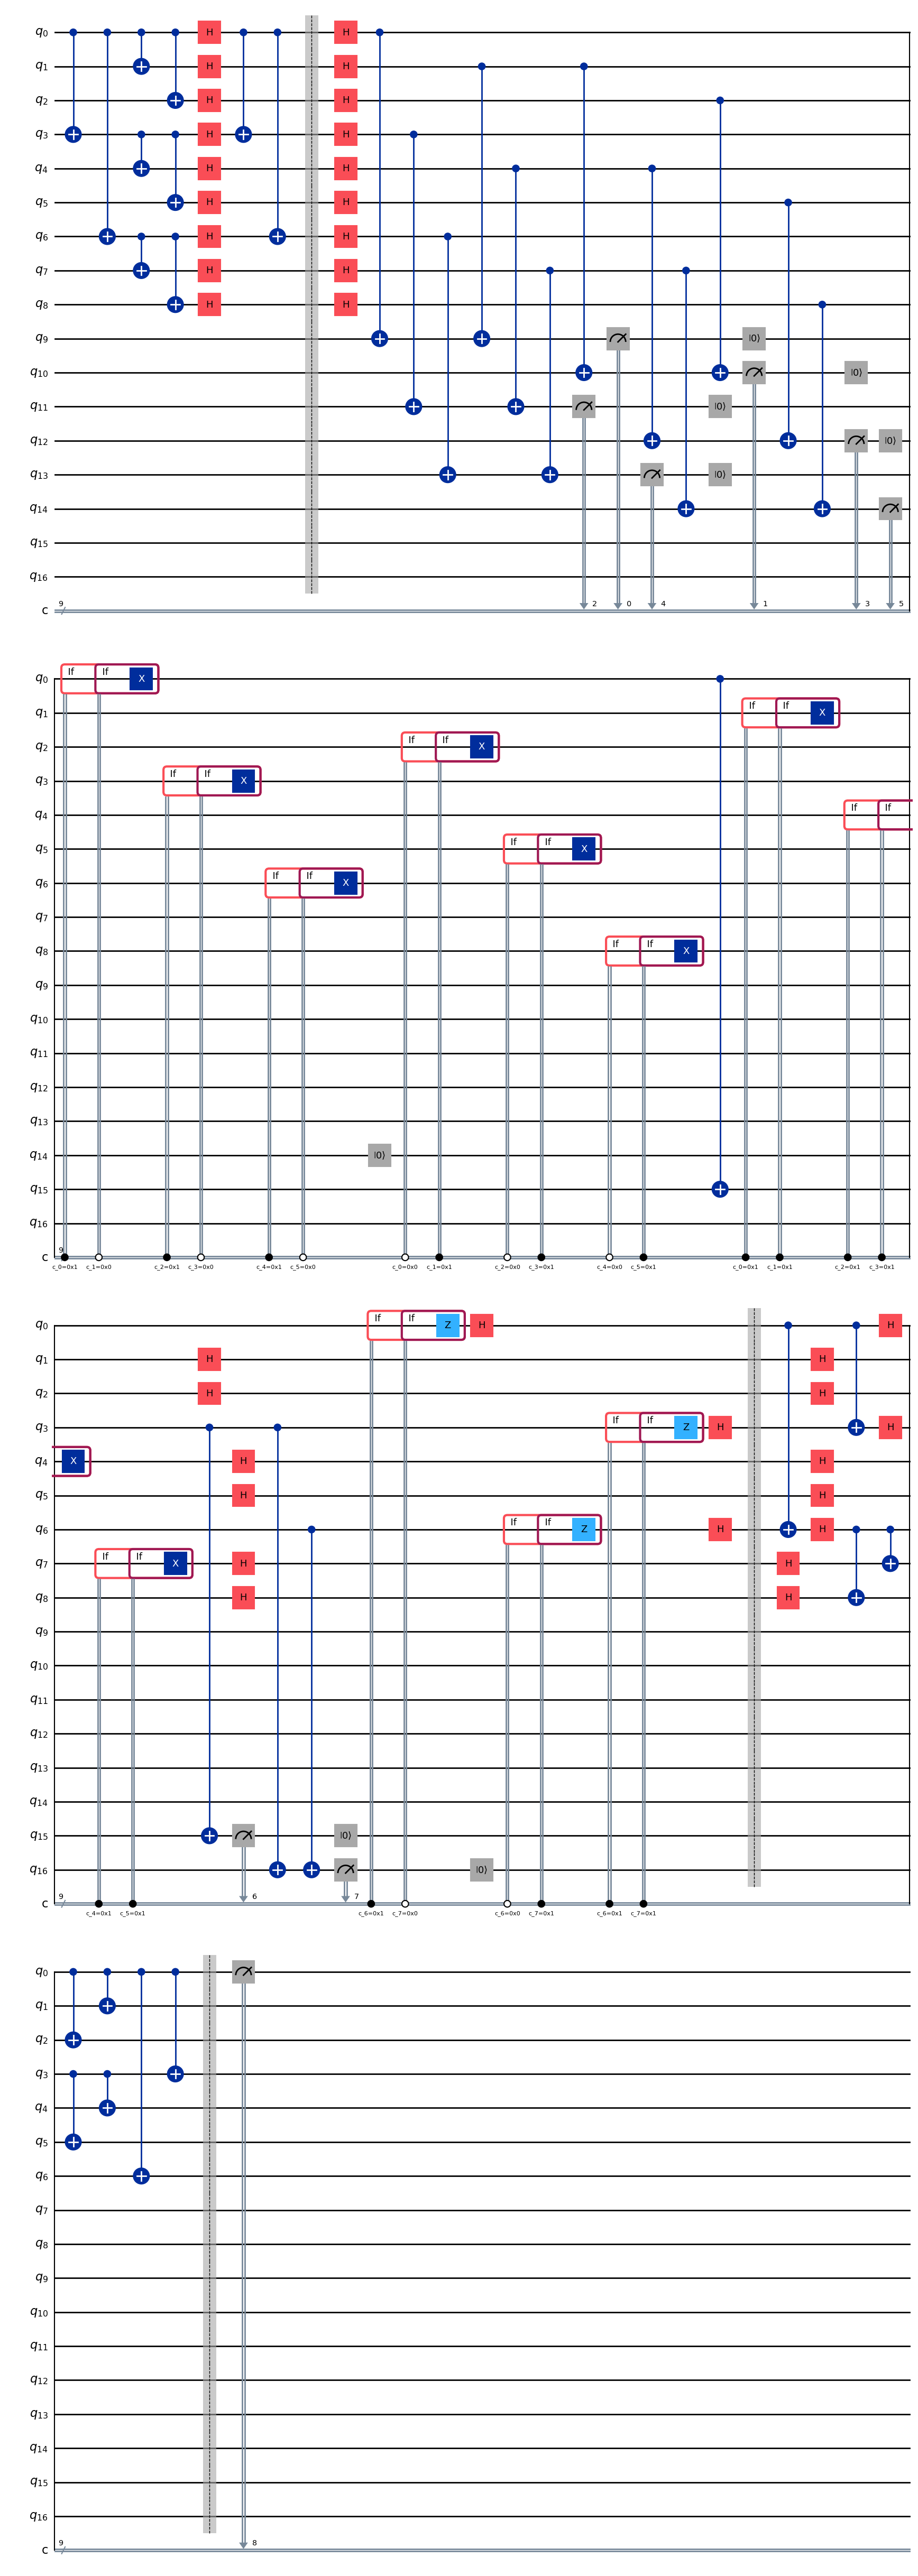


Measurement Results (Classical Bits, from LSB to MSB):
{'000000000': 1024}

Decoded Logical Qubit Measurement (from c[8]):
{'0': 1024}
Success Rate (Ideal |0> state): 100.00%
Shor code successfully corrected the error!


In [89]:
run_shor_simulation()

#### Simulation 2: BIT Flip Error on Qubit 4

--------------------------------------------------
           Running Shor 9-Qubit Code Simulation   
--------------------------------------------------
Preparing initial state |0> for logical qubit at index 0

Encoding Circuit...

Introducing Error...
  Introducing a BIT-FLIP error on qubit 4

Error Detection and Correction Circuit...

Decoding Circuit...

Final Measurement...

Full Circuit Diagram:


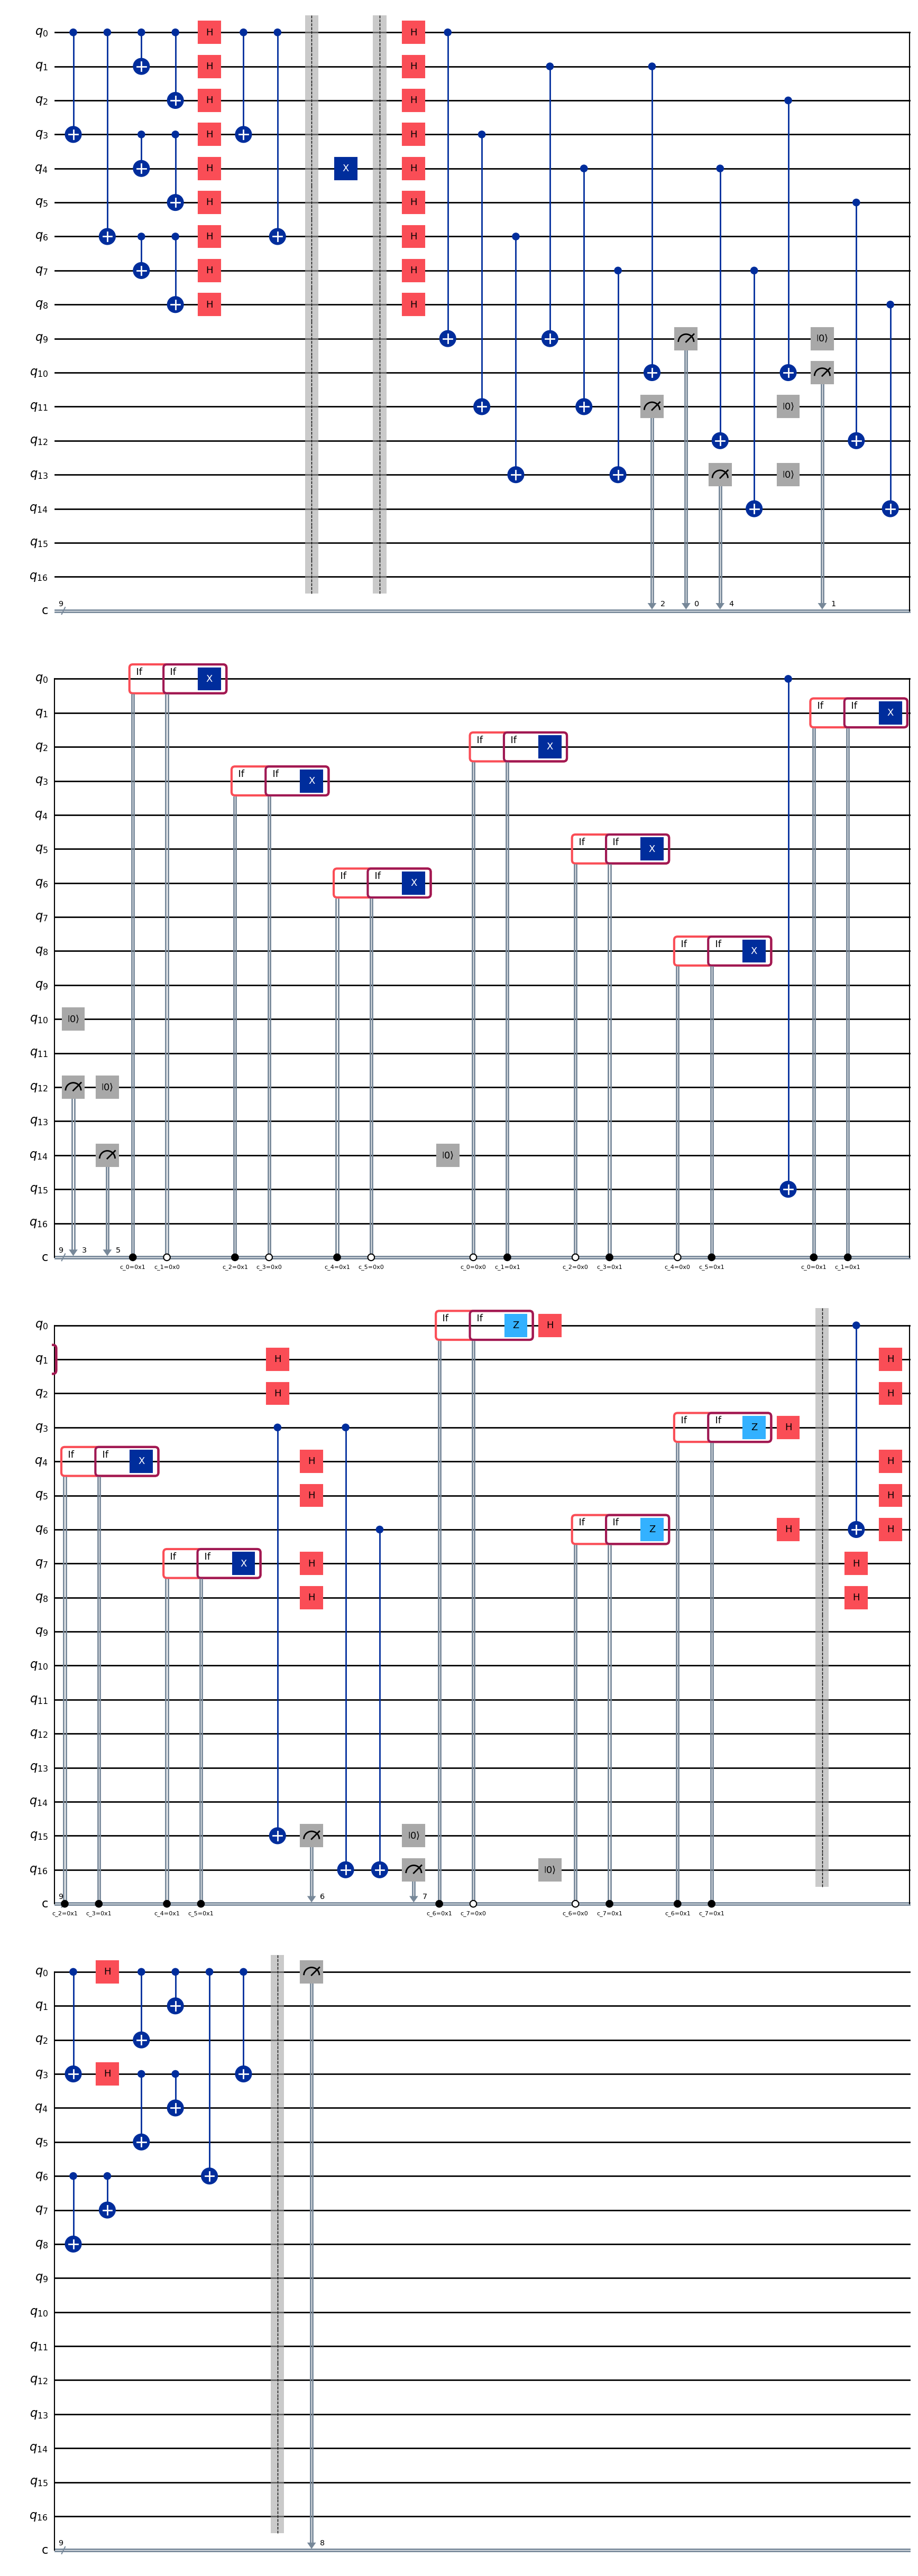


Measurement Results (Classical Bits, from LSB to MSB):
{'000000000': 1024}

Decoded Logical Qubit Measurement (from c[8]):
{'0': 1024}
Success Rate (Ideal |0> state): 100.00%
Shor code successfully corrected the error!


In [90]:
run_shor_simulation(error_qubit=4, error_type='bit_flip')

#### Simulation 3: Phase Flip Error on Qubit 1

--------------------------------------------------
           Running Shor 9-Qubit Code Simulation   
--------------------------------------------------
Preparing initial state |0> for logical qubit at index 0

Encoding Circuit...

Introducing Error...
  Introducing a PHASE-FLIP error on qubit 1

Error Detection and Correction Circuit...

Decoding Circuit...

Final Measurement...

Full Circuit Diagram:


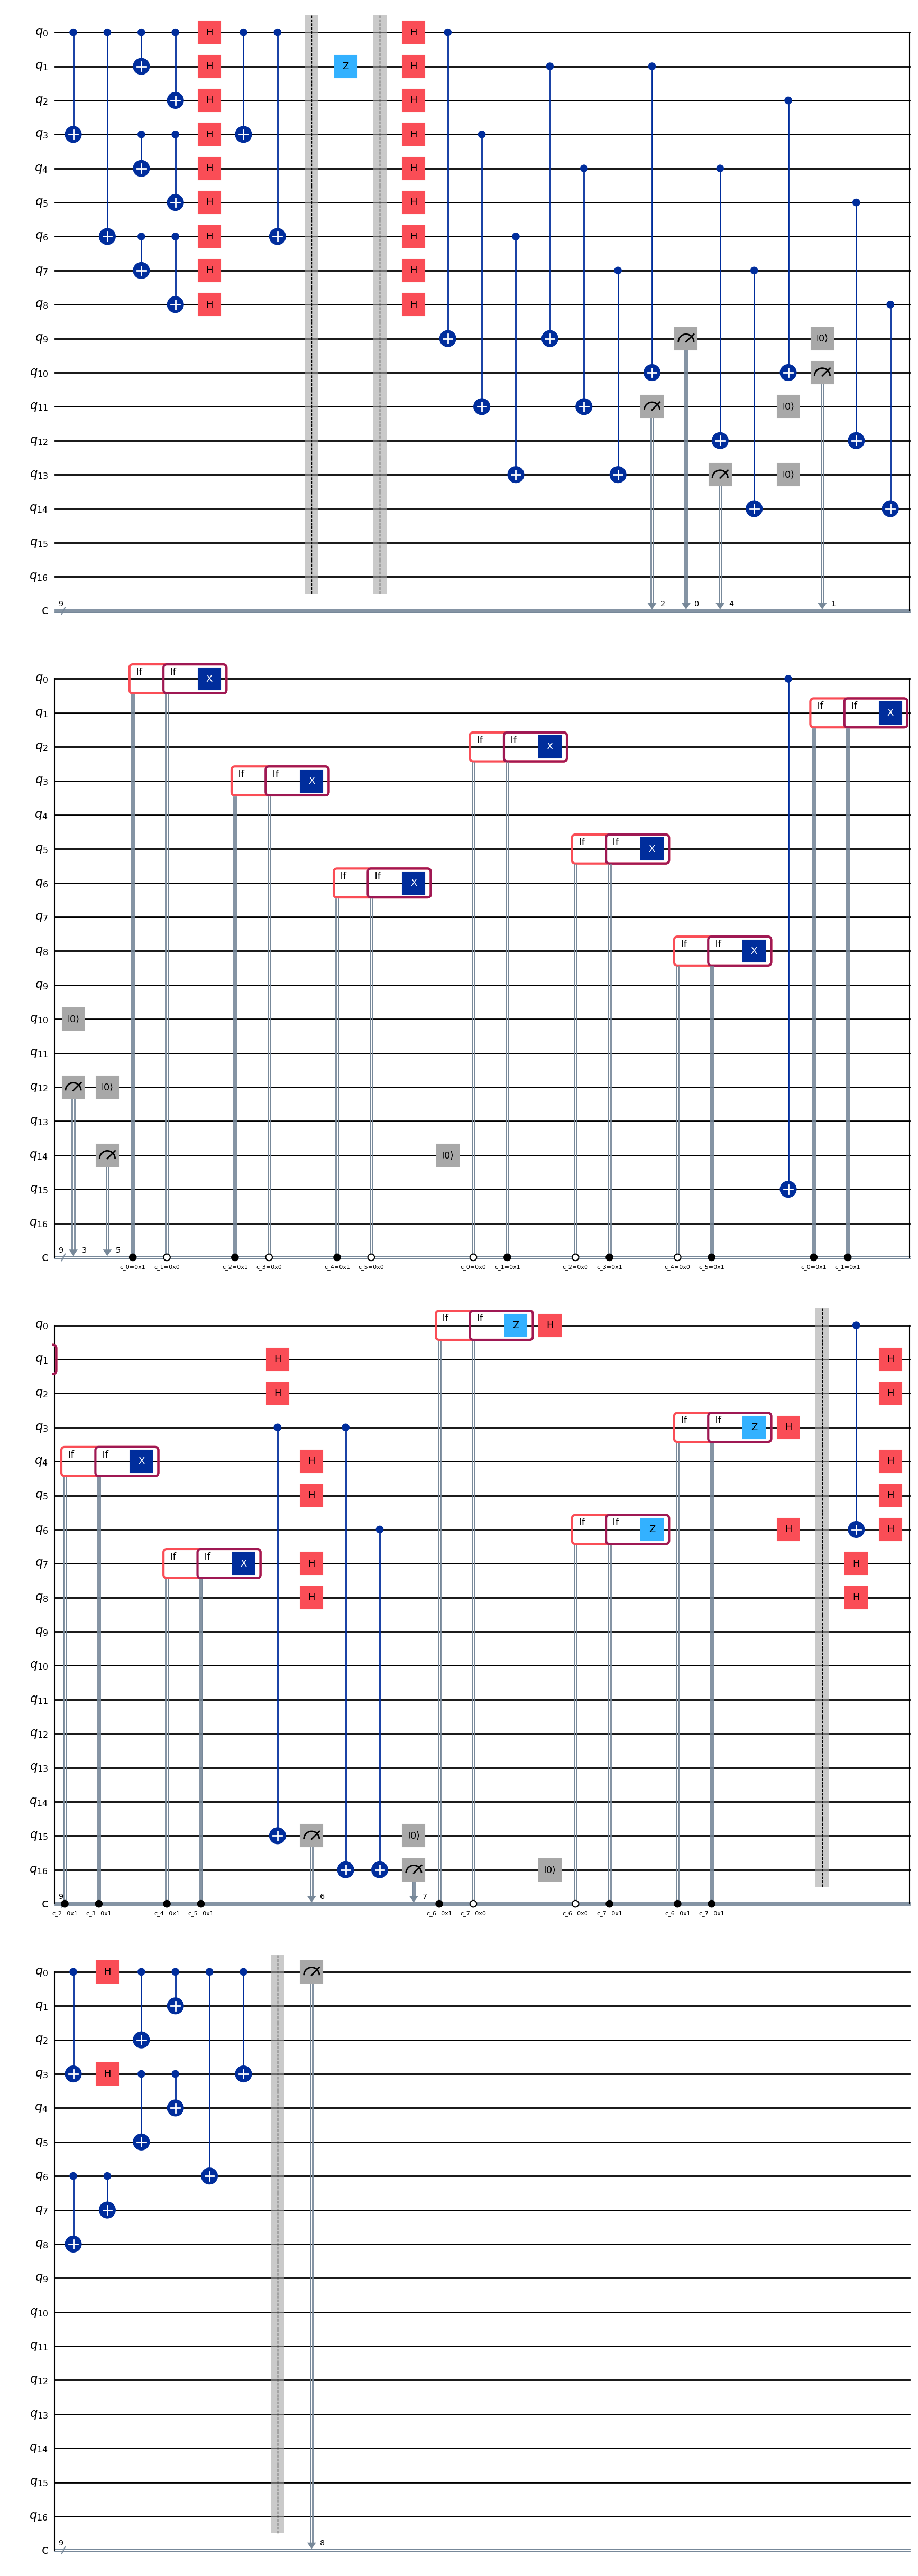


Measurement Results (Classical Bits, from LSB to MSB):
{'000000011': 1024}

Decoded Logical Qubit Measurement (from c[8]):
{'0': 1024}
Success Rate (Ideal |0> state): 100.00%
Shor code successfully corrected the error!


In [91]:
run_shor_simulation(error_qubit=1, error_type='phase_flip')

#### Simulation 4: Bit and Phase Flip error on Qubit 7

--------------------------------------------------
           Running Shor 9-Qubit Code Simulation   
--------------------------------------------------
Preparing initial state |0> for logical qubit at index 0

Encoding Circuit...

Introducing Error...
  Introducing a BIT-AND-PHASE-FLIP error on qubit 7

Error Detection and Correction Circuit...

Decoding Circuit...

Final Measurement...

Full Circuit Diagram:


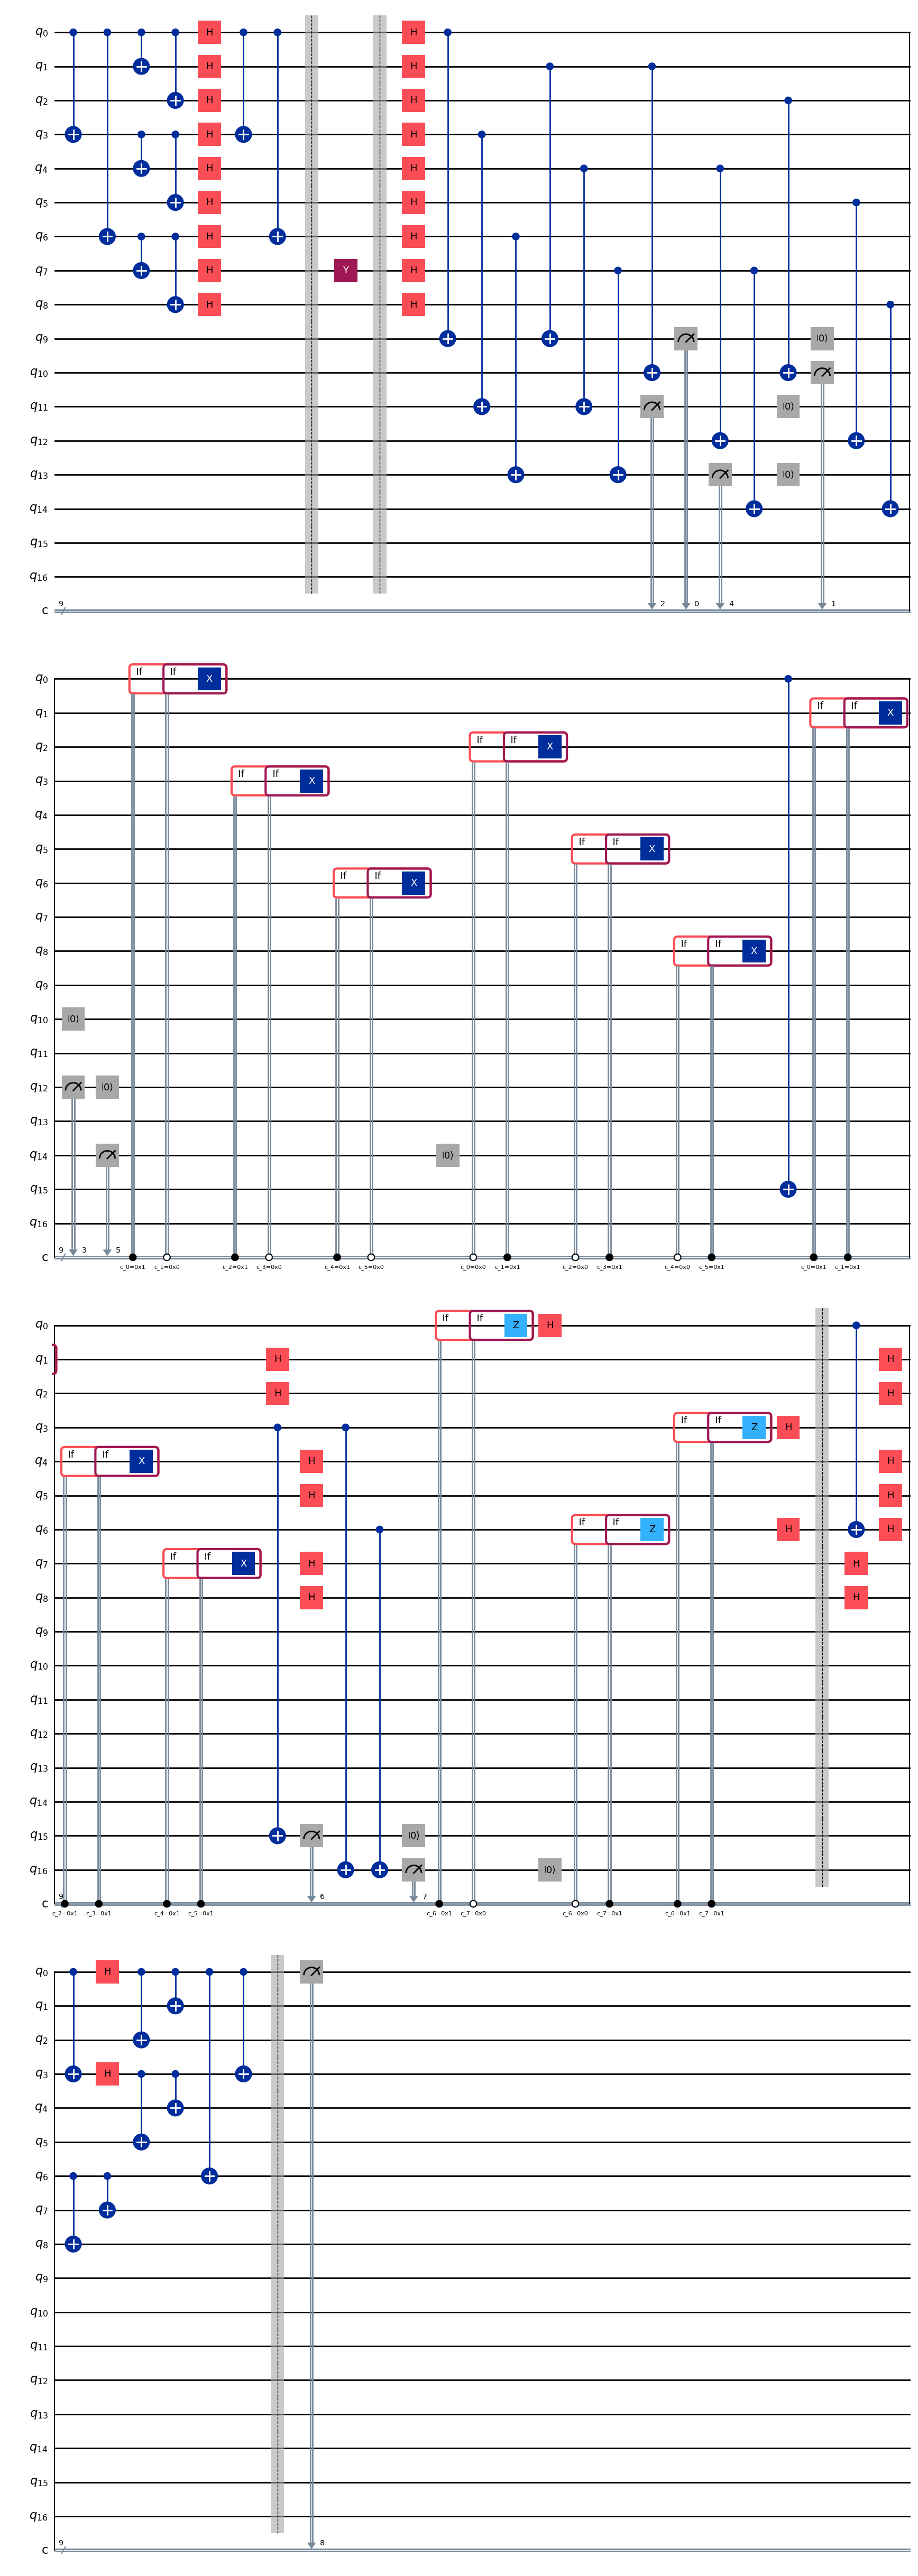


Measurement Results (Classical Bits, from LSB to MSB):
{'000110000': 1024}

Decoded Logical Qubit Measurement (from c[8]):
{'0': 1024}
Success Rate (Ideal |0> state): 100.00%
Shor code successfully corrected the error!


In [92]:
run_shor_simulation(error_qubit=7, error_type='bit_and_phase_flip')